In [1]:
cd ..

m:\OneDrive\Projects\federated_imputation_pc1


## Loading

In [86]:
%load_ext autoreload
%autoreload
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from dython.nominal import correlation_ratio
import missingno as msno
from src.fed_imp.sub_modules.missing_simulate.missing_adder_new import simulate_nan_new
from src.modules.evaluation.imputation_quality import rmse, ws_cols, sliced_ws
from src.notebook_utils import (
    visualize_ms, correlation, run_pred, sklearn_evaluation, NN_evaluation,
    run_simulation, simulate_scenario
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [91]:
experiment_config_template = {
  "num_clients": 3,
  "data": {
    "dataset_name": "nhis_income_pca",
    "normalize": True
  },
  "data_partition": {
    "strategy": "sample@p=4000",
    "params": {}
  },
  "missing_simulate": {
    "mr_strategy": "fixed",
    "mf_strategy": "all",
    "mm_strategy": "mnar_lr"
  },
  "imputation": {
    "initial_strategy_num": "mean",
    "initial_strategy_cat": "mode",
    "estimator_num": "ridge_cv",
    "estimator_cat": "logistic_cv",
    "imp_evaluation_model": "logistic",
    "imp_evaluation_params": {
      "tune_params": "gridsearch"
    },
    "clip": True
  },
  "agg_strategy_imp": {
    "strategy": "fedavg-s",
    "params": {
      "ms_field": "missing_cell_pct",
      "beta": 0.7
    }
  },
  "server_type": "fedavg_pytorch",
  "server": {
    "impute_mode": "instant",
    "imp_round": 20,
    "imp_local_epochs": 0,
    "pred_round": 0,
    "pred_local_epochs": 0,
    "model_fit_mode": "one_shot"
  },
  "pred_model": {
    "model_params": {
      "model": "2nn",
      "num_hiddens": 128,
      "model_init_config": None,
      "model_other_params": None
    },
    "train_params": {
      "batch_size": 128,
      "learning_rate": 0.001,
      "weight_decay": 0.0001,
      "pred_round": 200,
      "pred_local_epochs": 3
    }
  },
  "experiment": {
    "n_rounds": 1,
    "seed": 102931466,
    "mtp": False,
    "random_seed": 50,
    "num_process": 3,
    "test_size": 0.1,
    "track": True
  },
  "tune_params": False,
  "track": False,
  "tune_params": True,
  "prediction": False,
  "save_state": False,
  "test_size": 0.1,
  "algo_params": {
    "local": {},
    "fedavg-s": {},
    "fedwavg": {
      "alpha": 0.9
    },
    "fedmechw": {
      "client_thres": 1.0,
      "alpha": 1.0,
      "beta": 0.0
    },
    "fedmechclw": {
      "client_thres": 0.2,
      "thres1": 0.2,
      "alpha": 0.5
    },
    'testavg':{
        
    },
    'testavg2':{
        
    },
    'testavg3':{
        
    },
    "scale_factor": 4
  }
}

server_config_tmpl = {
    "server_name": 'fedavg_mlp_pytorch_pred',
    "server_pred_config": {
        "model_params": {
            "model": "2nn",
            "num_hiddens": 32,
            "model_init_config": None,
            "model_other_params": None
        },
        "train_params": {
            "batch_size": 128,
            "learning_rate": 0.001,
            "weight_decay": 0.001,
            "pred_round": 1000,
            "pred_local_epochs": 5,
            'local_epoch': 5,
            'sample_pct': 1
        }
    },
    "server_config": {
        'pred_rounds': 1,
        'seed': 21
    }
}

In [9]:
trackers = {}
rets ={}
mr_strategy = 'fixed@mr=0.5'

# NHIS

## Clients MNAR 3

### Local

Shape of raw data:  (16868, 1418)
Shape of data after dropping columns only contains one value:  (14585, 1392)
Shape of data after dropping high cardinality columns:  (14585, 1390)
Shape of data remove columns with missing values:  (14585, 406)
['WTIA_HH', 'WTFA_HH', 'WTFA_FAM', 'WTIA', 'WTFA', 'WTIA_SA', 'WTFA_SA']
['INCGRP4', 'INCGRP5', 'RAT_CAT5', 'RAT_CAT4', 'BMI', 'AGE_P', 'WRKMYR', 'EDUC1', 'PRIVATE', 'HIKINDNA']
(14585, 103)
(14585, 103) (14585, 7) (14585,)
Shape of data after one-hot encoding:  (14585, 104)
Shape of data after PCA: (14585, 30)
sample-evenly {}
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']
(4376, 31)


2023-07-27 10:16:12.822 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-07-27 10:16:12.823 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-07-27 10:16:47.517 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-07-27 10:16:47.518 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-07-27 10:17:15.275 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-07-27 10:17:15.276 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-07-27 10:17:42.664 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-07-27 10:17:42.664 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 

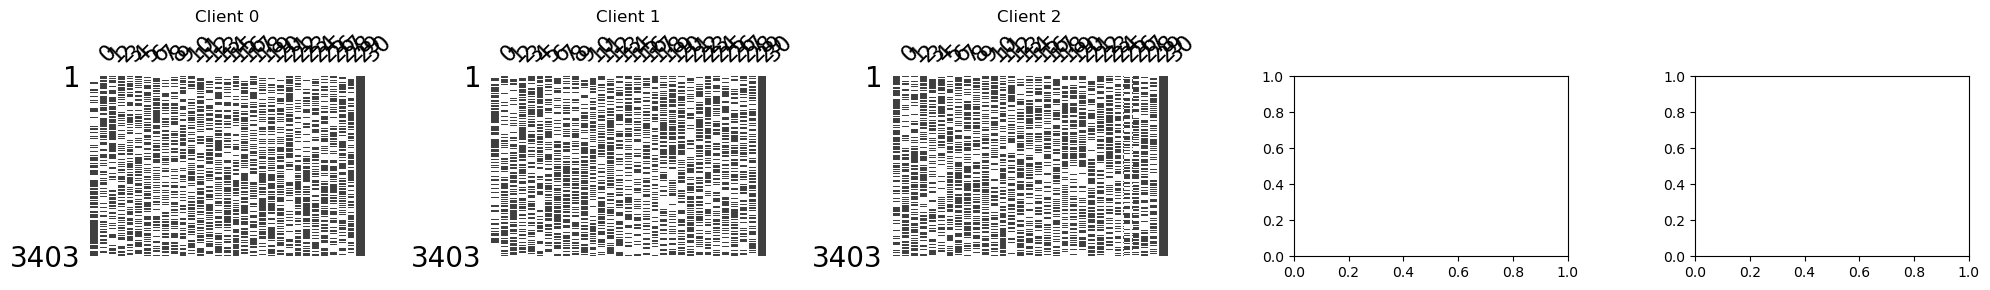

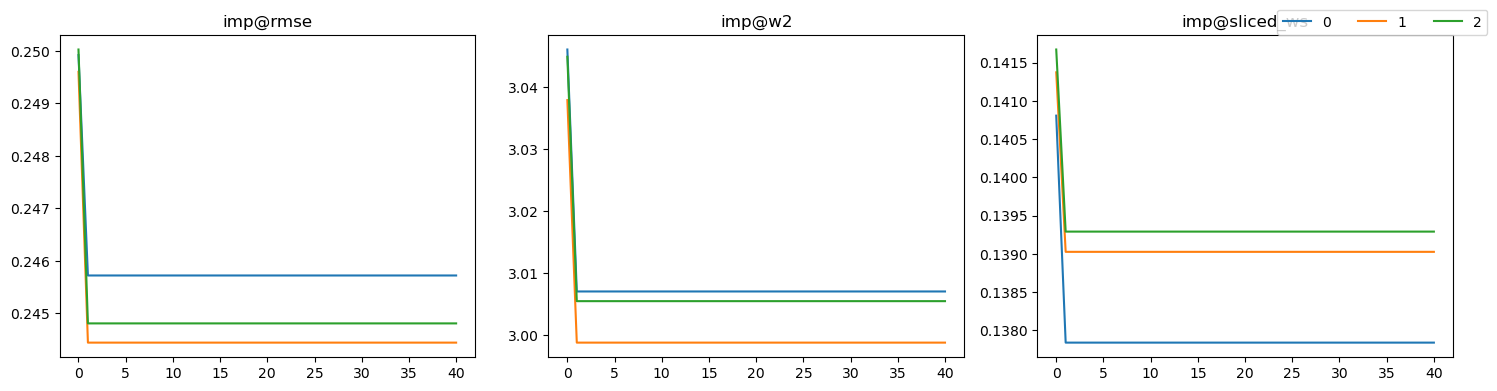

{'imp@rmse': 0.24499025432369048, 'imp@ws': 3.003702932573556, 'imp@sliced_ws': 0.13871740080188003}


In [10]:
name = 'mnar_lr12_local'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'nhis_income_pca'
config2['num_clients'] = 3
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremel1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'local'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [6]:
pred_ret = NN_evaluation(
    rets['mnar_lr12_local'], type='fedavg', n_rounds=500, server_config_tmpl = server_config_tmpl
)

2023-07-22 19:05:06.862 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 50, test_accu: 0.6059, test_f1: 0.6011, val_loss: 0.7860, val_accu: 0.5283, val_f1: 0.5209
2023-07-22 19:06:16.718 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 100, test_accu: 0.6136, test_f1: 0.6103, val_loss: 0.8119, val_accu: 0.5225, val_f1: 0.5133
2023-07-22 19:07:22.281 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 150, test_accu: 0.6091, test_f1: 0.6062, val_loss: 0.8470, val_accu: 0.5196, val_f1: 0.5098
2023-07-22 19:08:29.724 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 200, test_accu: 0.5996, test_f1: 0.5971, val_loss: 0.8976, val_accu: 0.5154, val_f1: 0.5048
2023-07-22 19:09:45.464 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 250, test_accu: 0.5940, test_f1: 0.591

0.6582209754773324


### Simple Average

Shape of raw data:  (16868, 1418)
Shape of data after dropping columns only contains one value:  (14585, 1392)
Shape of data after dropping high cardinality columns:  (14585, 1390)
Shape of data remove columns with missing values:  (14585, 406)
['WTIA_HH', 'WTFA_HH', 'WTFA_FAM', 'WTIA', 'WTFA', 'WTIA_SA', 'WTFA_SA']
['INCGRP4', 'INCGRP5', 'RAT_CAT5', 'RAT_CAT4', 'BMI', 'AGE_P', 'WRKMYR', 'EDUC1', 'PRIVATE', 'HIKINDNA']
(14585, 103)
(14585, 103) (14585, 7) (14585,)
Shape of data after one-hot encoding:  (14585, 104)
Shape of data after PCA: (14585, 30)
sample-evenly {}
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']
(4376, 31)


2023-07-27 11:23:42.797 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-07-27 11:23:42.799 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-07-27 11:24:39.677 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-07-27 11:24:39.678 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-07-27 11:25:40.791 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-07-27 11:25:40.792 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-07-27 11:25:47.308 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 127.23927589994855


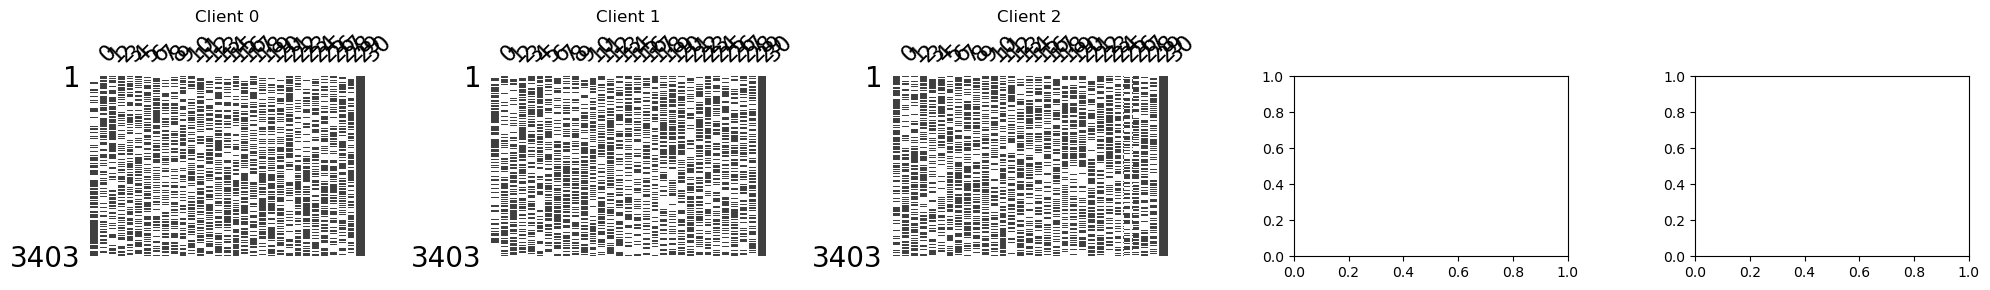

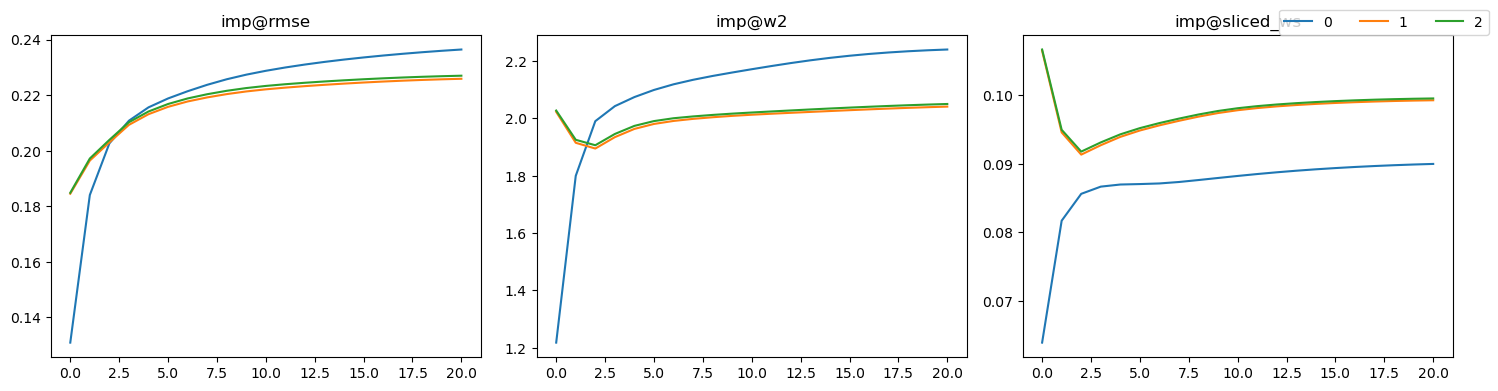

{'imp@rmse': 0.22911674262415918, 'imp@ws': 2.103927369235429, 'imp@sliced_ws': 0.09613507843662782}


In [87]:
name = 'mnar_lr121_fedavg-s'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'nhis_income_pca'
config2['num_clients'] = 3
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremel1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedavg-s'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

### Our

Shape of raw data:  (16868, 1418)
Shape of data after dropping columns only contains one value:  (14585, 1392)
Shape of data after dropping high cardinality columns:  (14585, 1390)
Shape of data remove columns with missing values:  (14585, 406)
['WTIA_HH', 'WTFA_HH', 'WTFA_FAM', 'WTIA', 'WTFA', 'WTIA_SA', 'WTFA_SA']
['INCGRP4', 'INCGRP5', 'RAT_CAT5', 'RAT_CAT4', 'BMI', 'AGE_P', 'WRKMYR', 'EDUC1', 'PRIVATE', 'HIKINDNA']
(14585, 103)
(14585, 103) (14585, 7) (14585,)
Shape of data after one-hot encoding:  (14585, 104)
Shape of data after PCA: (14585, 30)
sample-evenly {}
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']
(4376, 31)


2023-07-27 11:42:18.467 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-07-27 11:42:18.468 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-07-27 11:43:18.749 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-07-27 11:43:18.750 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-07-27 11:44:20.430 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-07-27 11:44:20.431 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-07-27 11:44:26.743 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 131.04309620009735


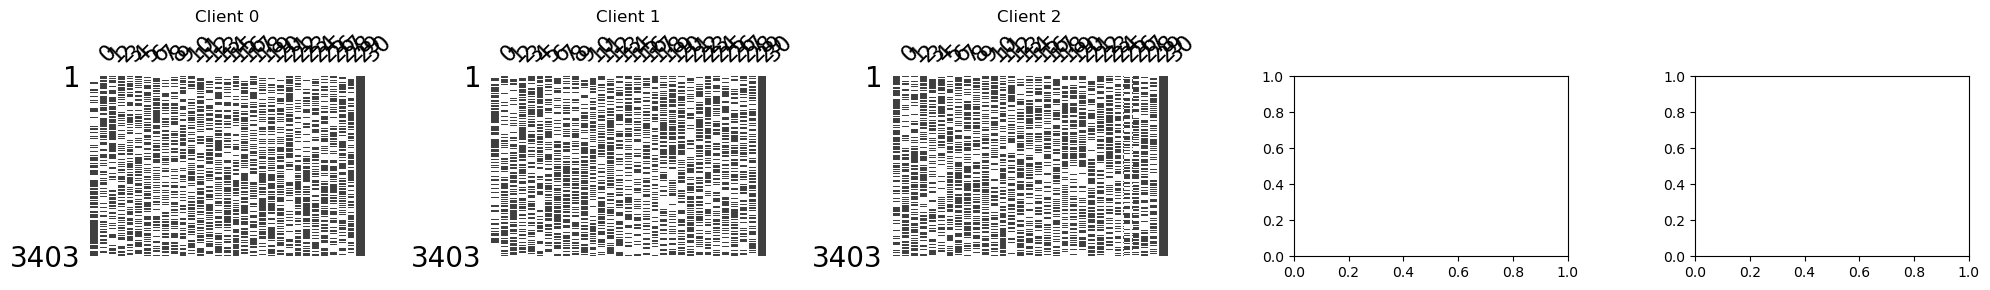

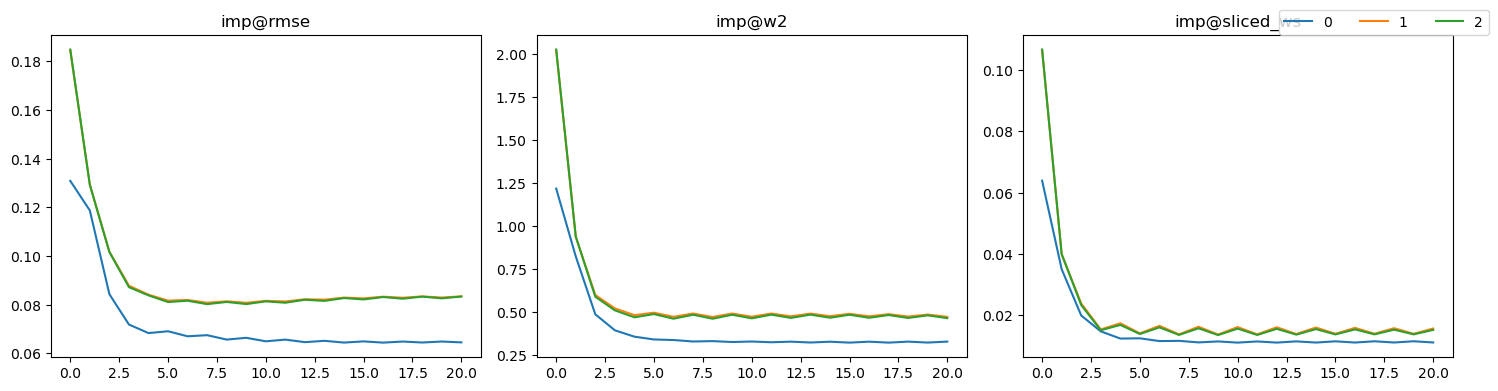

{'imp@rmse': 0.07692537094058897, 'imp@ws': 0.4274098012138797, 'imp@sliced_ws': 0.013691320796776936}


In [92]:
name = 'mnar_lr121_fedmechw'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'nhis_income_pca'
config2['num_clients'] = 3
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremel1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedmechw'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

## Clients MNAR 11

### Simple Averaging

Shape of raw data:  (16868, 1418)
Shape of data after dropping columns only contains one value:  (14585, 1392)
Shape of data after dropping high cardinality columns:  (14585, 1390)
Shape of data remove columns with missing values:  (14585, 406)
['WTIA_HH', 'WTFA_HH', 'WTFA_FAM', 'WTIA', 'WTFA', 'WTIA_SA', 'WTFA_SA']
['INCGRP4', 'INCGRP5', 'RAT_CAT5', 'RAT_CAT4', 'BMI', 'AGE_P', 'WRKMYR', 'EDUC1', 'PRIVATE', 'HIKINDNA']
(14585, 103)
(14585, 103) (14585, 7) (14585,)
Shape of data after one-hot encoding:  (14585, 104)
Shape of data after PCA: (14585, 30)
sample-evenly {}
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']
(4376, 31)


2023-07-27 11:30:46.931 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-07-27 11:30:46.932 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-07-27 11:32:06.409 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-07-27 11:32:06.410 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-07-27 11:33:31.626 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-07-27 11:33:31.627 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-07-27 11:33:40.098 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 175.45430510002188


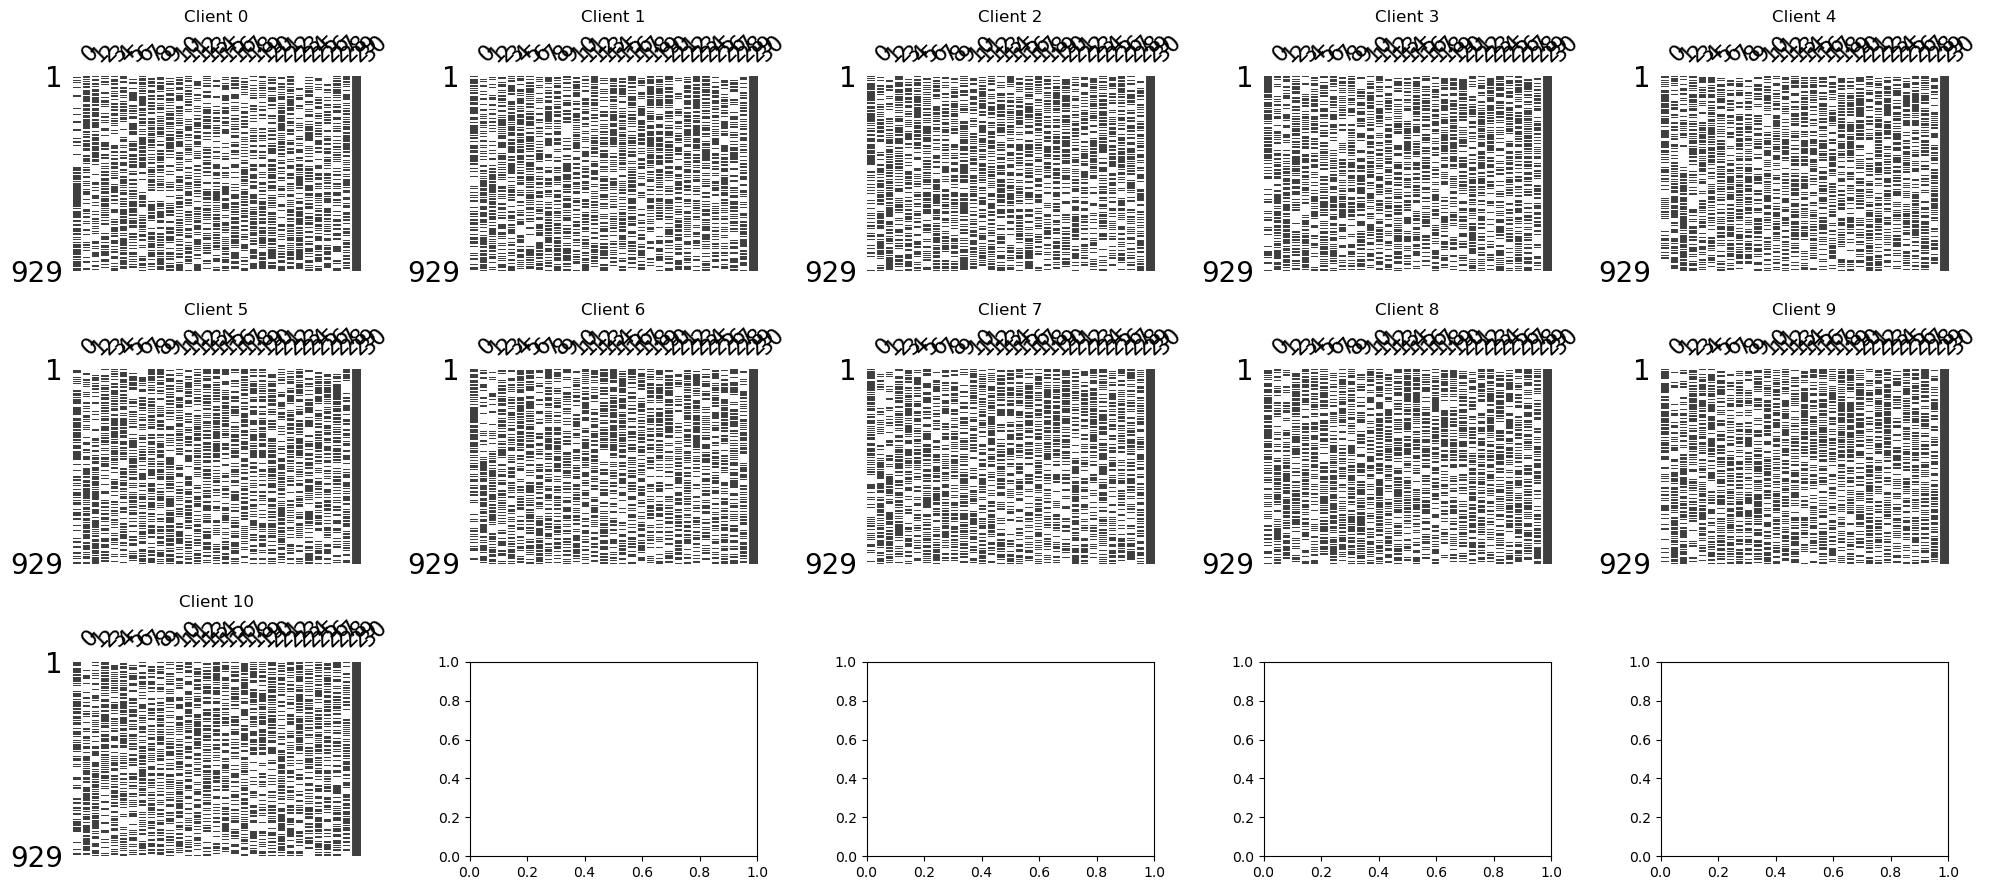

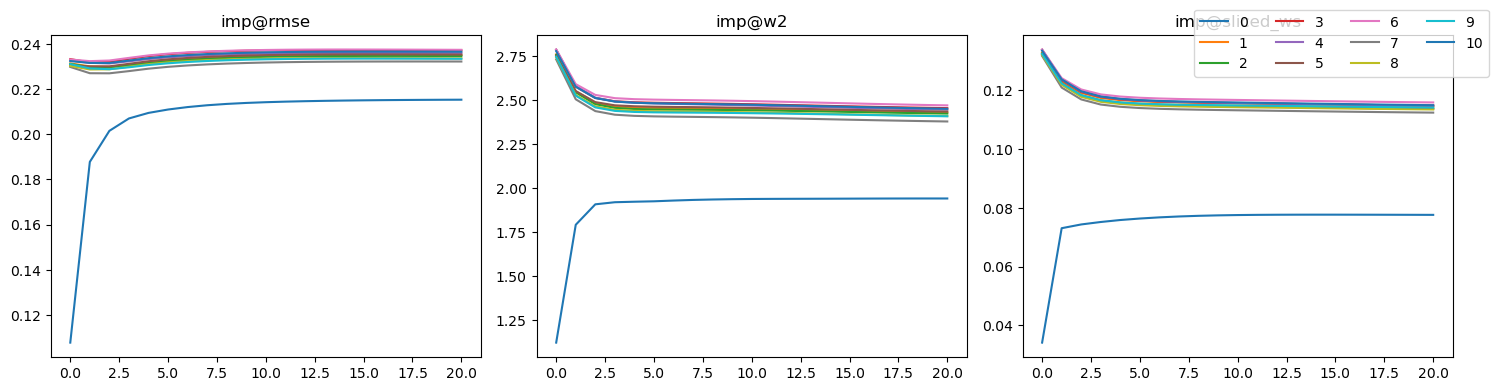

{'imp@rmse': 0.2332638568605701, 'imp@ws': 2.3895616619092963, 'imp@sliced_ws': 0.11109971904894629}


In [89]:
name = 'mnar_lr12_fedavg-s'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'nhis_income_pca'
config2['num_clients'] = 11
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremel1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedavg-s'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

### Ours

In [93]:
name = 'mnar_lr12_fedmechw'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'nhis_income_pca'
config2['num_clients'] = 11
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremel1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedmechw'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

Shape of raw data:  (16868, 1418)
Shape of data after dropping columns only contains one value:  (14585, 1392)
Shape of data after dropping high cardinality columns:  (14585, 1390)
Shape of data remove columns with missing values:  (14585, 406)
['WTIA_HH', 'WTFA_HH', 'WTFA_FAM', 'WTIA', 'WTFA', 'WTIA_SA', 'WTFA_SA']
['INCGRP4', 'INCGRP5', 'RAT_CAT5', 'RAT_CAT4', 'BMI', 'AGE_P', 'WRKMYR', 'EDUC1', 'PRIVATE', 'HIKINDNA']
(14585, 103)
(14585, 103) (14585, 7) (14585,)
Shape of data after one-hot encoding:  (14585, 104)
Shape of data after PCA: (14585, 30)
sample-evenly {}
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']
(4376, 31)


2023-07-27 11:44:39.071 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-07-27 11:44:39.072 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-07-27 11:46:03.329 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-07-27 11:46:03.330 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10


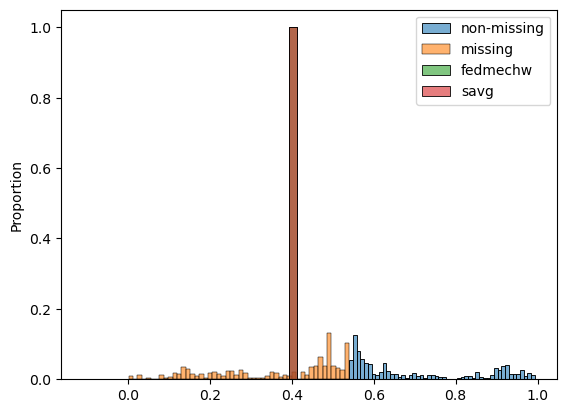

In [73]:
client_id = 0
feature_idx = 1
experiment = 'mnar_lr12'
clients_origin_data = rets['{}_fedmechw'.format(experiment)]['data']['origin_data']
clients_imp_data = rets['{}_fedmechw'.format(experiment)]['data']['imputed_data']
clients_msk = rets['{}_fedmechw'.format(experiment)]['data']['missing_mask']
#client_imp_data_local = rets['{}_local'.format(experiment)]['data']['imputed_data'][client_id, ...]
clients_imp_data_savg = rets['{}_fedavg-s'.format(experiment)]['data']['imputed_data']
split_indices = rets['{}_fedmechw'.format(experiment)]['data']['split_indices']

client_origin_data = np.split(clients_origin_data, split_indices)[client_id]
client_imp_data = np.split(clients_imp_data, split_indices)[client_id]
client_msk = np.split(clients_msk, split_indices)[client_id]
#client_imp_data_local = np.split(clients_imp_data_local, split_indices)[client_id, ...]
client_imp_data_savg = np.split(clients_imp_data_savg, split_indices)[client_id]

alpha = 0.6
bins = 50
stat = 'proportion'
sns.histplot(client_origin_data[:, feature_idx][~client_msk[:, feature_idx]], bins = bins, label = 'non-missing', stat=stat, alpha = alpha)
sns.histplot(client_origin_data[:, feature_idx][client_msk[:, feature_idx]], bins = bins, label = 'missing', stat=stat, alpha = alpha)
sns.histplot(client_imp_data[:, feature_idx][client_msk[:, feature_idx]], bins = bins, label = 'fedmechw', stat=stat, alpha = alpha)
#sns.histplot(client_imp_data_local[:, feature_idx][client_msk[:, feature_idx]], bins = bins, label = 'local', stat=stat, alpha = alpha)
sns.histplot(client_imp_data_savg[:, feature_idx][client_msk[:, feature_idx]], bins = bins, label = 'savg', stat=stat, alpha = alpha)
plt.legend()

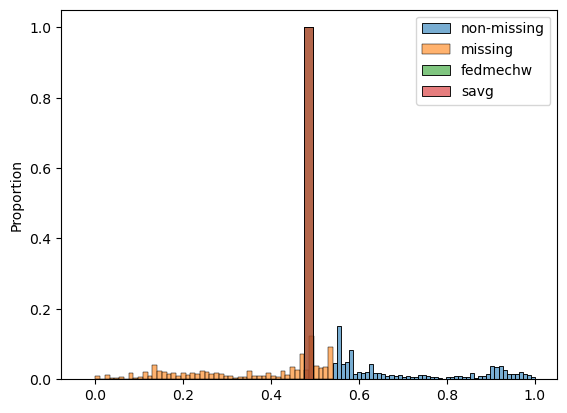

In [82]:
client_id = 0
feature_idx = 1
experiment = 'mnar_lr121'
clients_origin_data = rets['{}_fedmechw'.format(experiment)]['data']['origin_data']
clients_imp_data = rets['{}_fedmechw'.format(experiment)]['data']['imputed_data']
clients_msk = rets['{}_fedmechw'.format(experiment)]['data']['missing_mask']
#client_imp_data_local = rets['{}_local'.format(experiment)]['data']['imputed_data'][client_id, ...]
clients_imp_data_savg = rets['{}_fedavg-s'.format(experiment)]['data']['imputed_data']
split_indices = rets['{}_fedmechw'.format(experiment)]['data']['split_indices']

client_origin_data = np.split(clients_origin_data, split_indices)[client_id]
client_imp_data = np.split(clients_imp_data, split_indices)[client_id]
client_msk = np.split(clients_msk, split_indices)[client_id]
#client_imp_data_local = np.split(clients_imp_data_local, split_indices)[client_id, ...]
client_imp_data_savg = np.split(clients_imp_data_savg, split_indices)[client_id]

alpha = 0.6
bins = 50
stat = 'proportion'
sns.histplot(client_origin_data[:, feature_idx][~client_msk[:, feature_idx]], bins = bins, label = 'non-missing', stat=stat, alpha = alpha)
sns.histplot(client_origin_data[:, feature_idx][client_msk[:, feature_idx]], bins = bins, label = 'missing', stat=stat, alpha = alpha)
sns.histplot(client_imp_data[:, feature_idx][client_msk[:, feature_idx]], bins = bins, label = 'fedmechw', stat=stat, alpha = alpha)
#sns.histplot(client_imp_data_local[:, feature_idx][client_msk[:, feature_idx]], bins = bins, label = 'local', stat=stat, alpha = alpha)
sns.histplot(client_imp_data_savg[:, feature_idx][client_msk[:, feature_idx]], bins = bins, label = 'savg', stat=stat, alpha = alpha)
plt.legend()

# Heart

## Clients MNAR 3

### Simple Averaging

(319795, 39)
(319795, 3)
(54746, 25)
(54746, 26)
sample-evenly {}
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']
(16424, 26)


2023-07-27 11:05:22.033 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-07-27 11:05:22.034 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-07-27 11:06:59.578 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-07-27 11:06:59.579 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-07-27 11:08:53.139 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-07-27 11:08:53.140 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-07-27 11:09:04.557 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 233.54283030005172


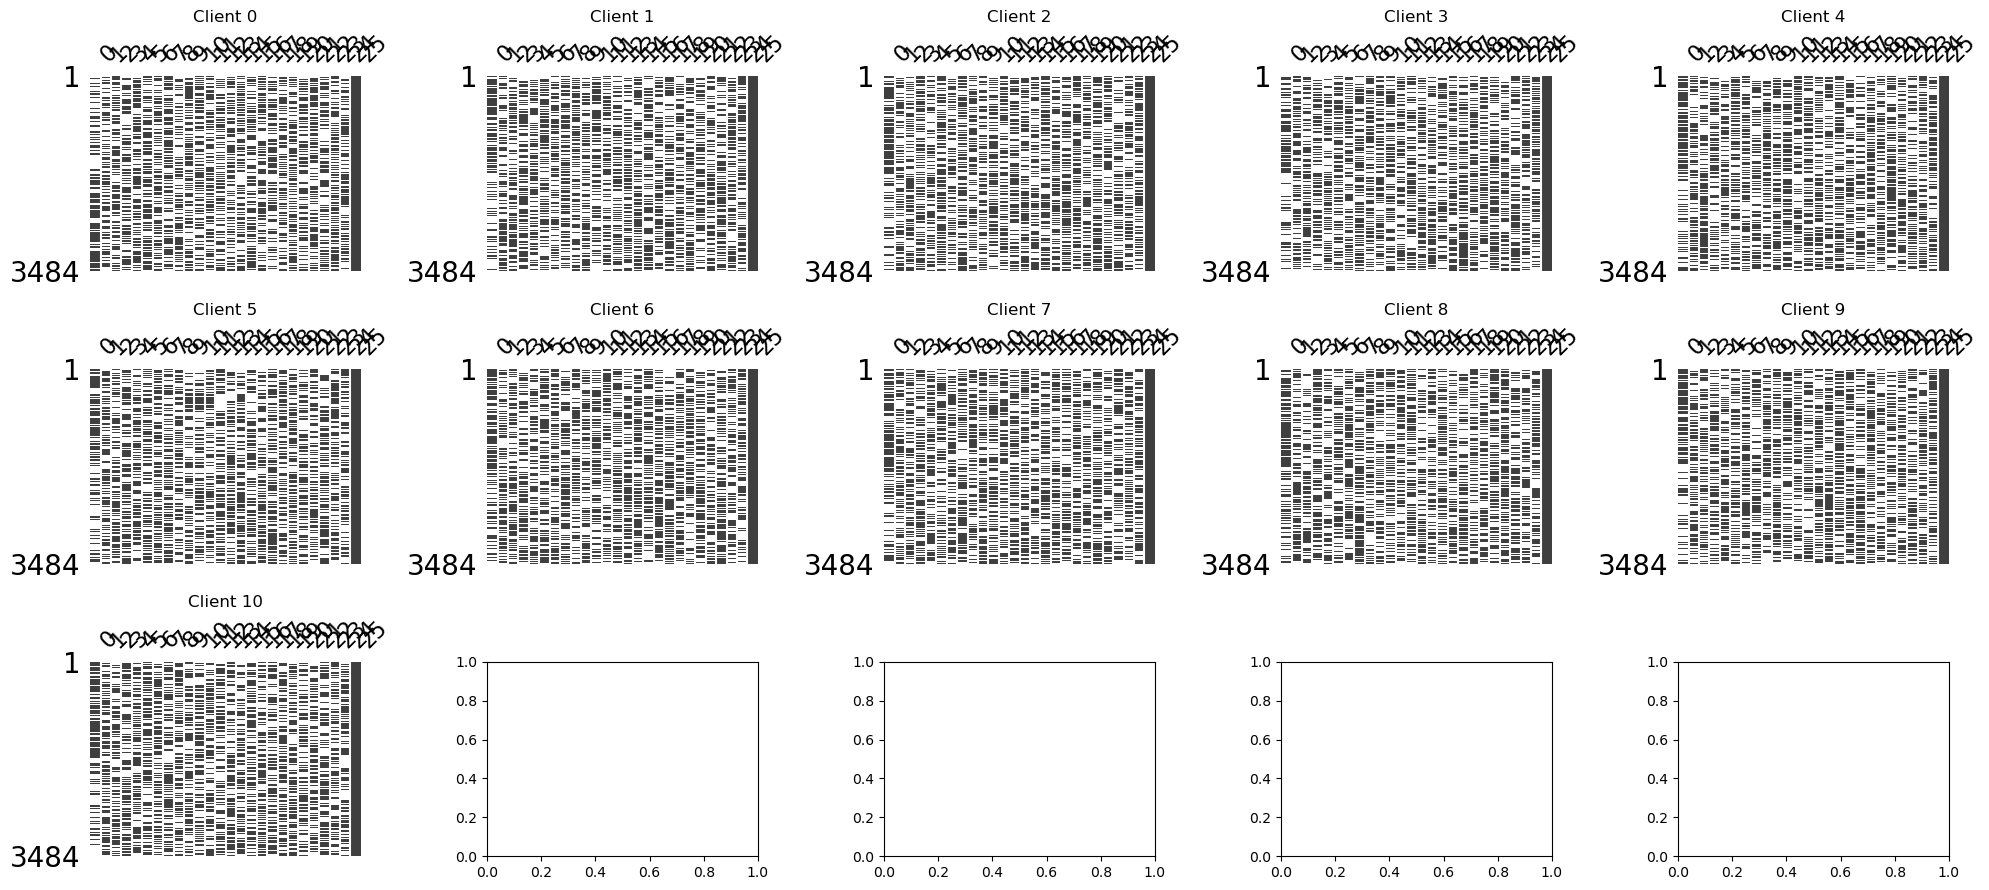

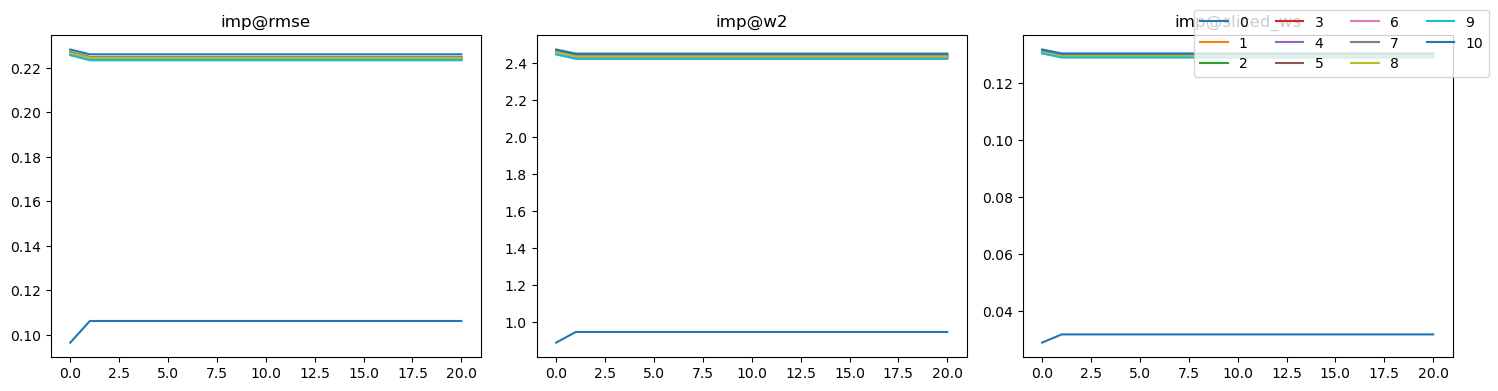

{'imp@rmse': 0.21362343208827547, 'imp@ws': 2.2982317653377806, 'imp@sliced_ws': 0.12080579359965729}


In [84]:
name = 'mnar_lr_heart_fedavg-s'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'heart'
config2['num_clients'] = 11
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremel1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedavg-s'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

### Ours

(319795, 39)
(319795, 3)
(54746, 25)
(54746, 26)
sample-evenly {}
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']
(16424, 26)


2023-07-27 11:09:25.480 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-07-27 11:09:25.481 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-07-27 11:10:59.920 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-07-27 11:10:59.921 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-07-27 11:12:51.138 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-07-27 11:12:51.139 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-07-27 11:13:04.741 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 228.93384040007368


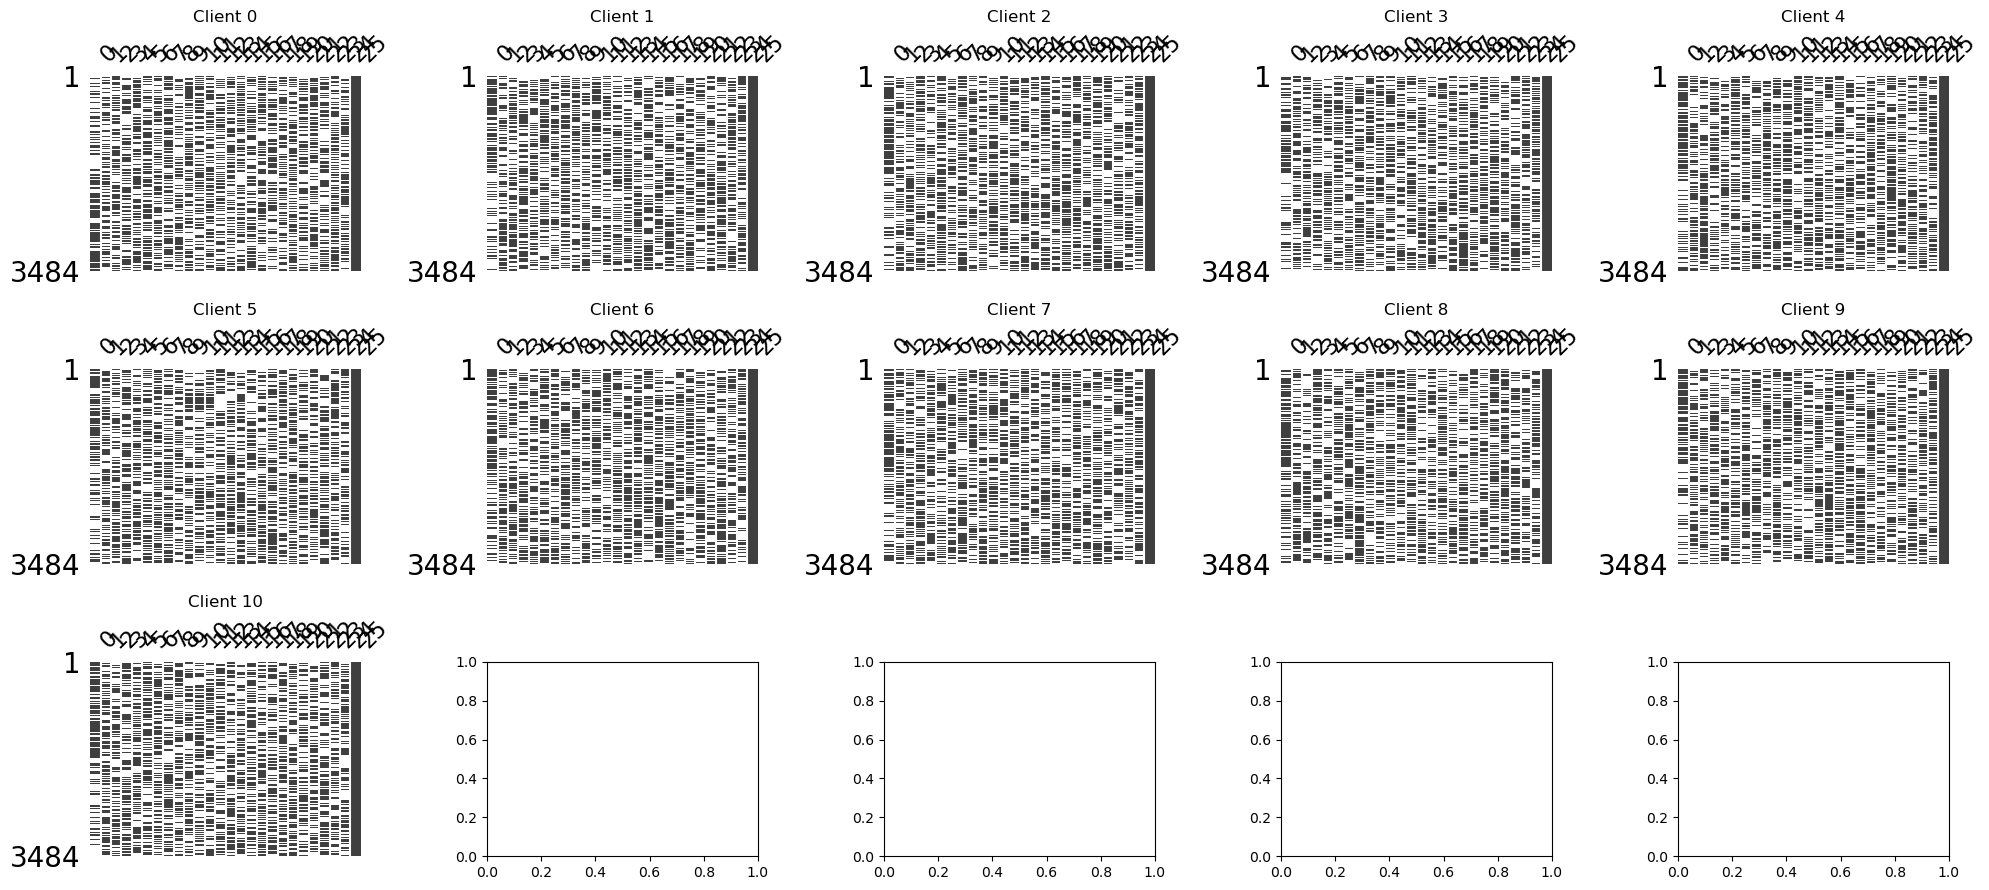

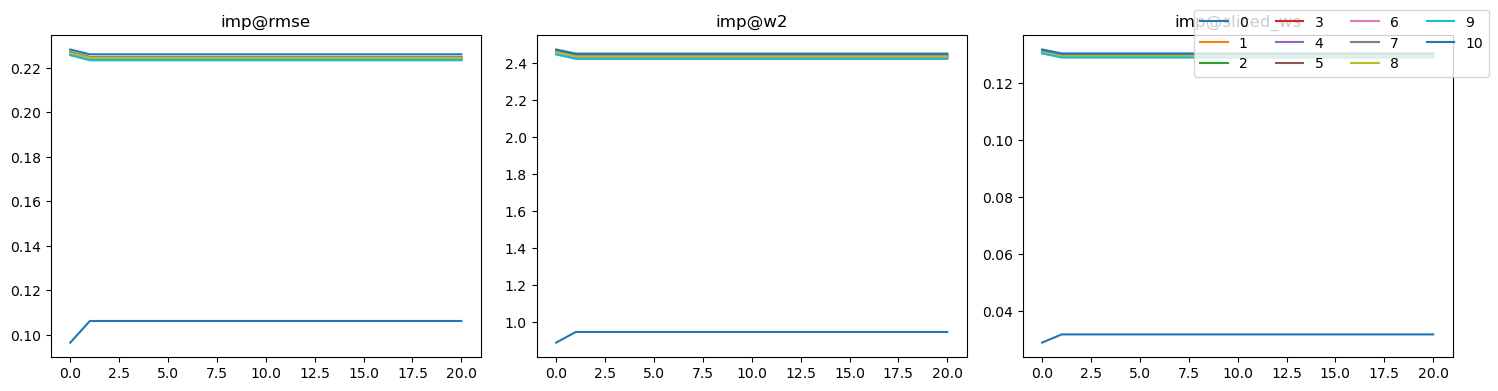

{'imp@rmse': 0.21362343208827547, 'imp@ws': 2.2982317653377806, 'imp@sliced_ws': 0.12080579359965729}


In [85]:
name = 'mnar_lr_heart_fedmechw'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'heart'
config2['num_clients'] = 11
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremel1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedavg-s'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()